Here we're going to demonstrate the usage of each XAI method on some example dataset.

Methods will be
- LIME
- SHAP
- Dice

# SpaceShip Titanic Dataset
To download the dataset proceed the following link https://www.kaggle.com/competitions/spaceship-titanic. And extract the downloaded dataset into `datasets/spaceship-titanic`.

In [1]:
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import lime
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## EDA

In [2]:
df_train = pd.read_csv('datasets/spaceship-titanic/train.csv')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [4]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [5]:
df_train.HomePlanet.value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [6]:
df_train.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

(array([ 591.,  649., 2089., 1976., 1350.,  893.,  536.,  294.,  106.,
          30.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

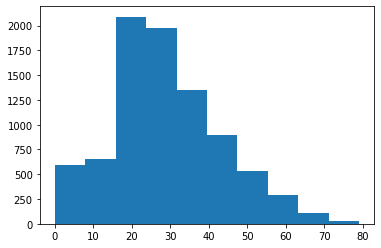

In [7]:
plt.hist(df_train.Age)

In [8]:
print(f'Training samples shape with NA values: {df_train.shape}')
print(f'Training samples shape without NA values: {df_train.dropna().shape}')


Training samples shape with NA values: (8693, 14)
Training samples shape without NA values: (6606, 14)


In [9]:
df_train_without_na = df_train.dropna()
df_train_without_na.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
df_train_without_na.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.074783,0.135844,0.042314,0.123820,0.105031,-0.082553
RoomService,0.074783,1.000000,-0.013614,0.060478,0.012472,-0.026002,-0.247291
FoodCourt,0.135844,-0.013614,1.000000,-0.012320,0.215995,0.216997,0.055025
ShoppingMall,0.042314,0.060478,-0.012320,1.000000,0.022168,0.000383,0.011602
Spa,0.123820,0.012472,0.215995,0.022168,1.000000,0.149447,-0.219854
VRDeck,0.105031,-0.026002,0.216997,0.000383,0.149447,1.000000,-0.207950
Transported,-0.082553,-0.247291,0.055025,0.011602,-0.219854,-0.207950,1.000000


the correlation results shows that `HomePlanet`, `CryoSleep`, `VIP`, `Destination` has the highest correlation with `Transported`. So we're going to use them in prediction.

In [11]:
df_train_without_na.Spa.value_counts()

0.0       4109
1.0        113
2.0         80
5.0         44
3.0         44
          ... 
1792.0       1
330.0        1
1924.0       1
3440.0       1
1643.0       1
Name: Spa, Length: 1143, dtype: int64

In [12]:
df_train_without_na.VIP = df_train_without_na.VIP.astype(bool)

In [13]:
cols = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination' ]

In [14]:
df_train_without_na.Destination.value_counts()

TRAPPIST-1e      4576
55 Cancri e      1407
PSO J318.5-22     623
Name: Destination, dtype: int64

In [15]:
## set of columns that will be used in training
cols_training = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Age']

In [16]:
df_train_X = pd.get_dummies(df_train_without_na[cols_training], columns=cols)

In [17]:
## drop the ages with zero values
df_train_X = df_train_X.drop(df_train_X[df_train_X.Age == 0].index)

In [18]:
df_train_X.head()

,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,39.0,0,1,0,1,0,1,0,0,0,1
1,24.0,1,0,0,1,0,1,0,0,0,1
2,58.0,0,1,0,1,0,0,1,0,0,1
3,33.0,0,1,0,1,0,1,0,0,0,1
4,16.0,1,0,0,1,0,1,0,0,0,1


In [19]:
df_train_Y = df_train_without_na[df_train_without_na.Age != 0].Transported
df_train_Y.shape

(6466,)

## Training phase

### SVM Model

In [20]:
svm_model = SVC(random_state=123)
svm_model.fit(df_train_X, df_train_Y)

SVC(random_state=123)

In [21]:
train_pred = svm_model.predict(df_train_X)
confusion_matrix_svm_trn = confusion_matrix(df_train_Y, train_pred)

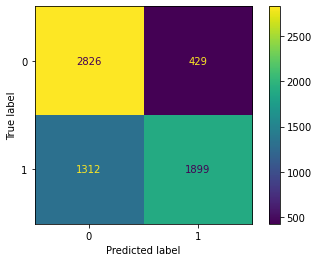

In [22]:
ConfusionMatrixDisplay(confusion_matrix_svm_trn).plot()

In [23]:
## Accuracy
acc = 0
for i in range(0, 2):
    acc += confusion_matrix_svm_trn[i, i]
acc * 100 / len(train_pred)

73.0745437673987

The training Accuracy is 73.5

### XGBoost model

First convert data into Dmatrix form

In [24]:
dtrain = xgb.DMatrix(df_train_X, label=df_train_Y, feature_names=df_train_X.columns)

In [25]:
xgb_params = {
'eta': 0.3,
'max_depth': 6,
'min_child_weight': 1,
'objective': 'binary:logistic',
'eval_metric': 'auc', #A
'nthread': 8,
'seed': 1,
'silent': 1
}
xgb_model = xgb.train(xgb_params, dtrain=dtrain, num_boost_round=10)

[16:53:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [28]:
xgb_train_pred = xgb_model.predict(dtrain)

In [29]:
def find_acc(confusion_matrix):
    """
    Find the accuracy of a binary classification problem using confusion matrix

    Parameters:
    ------------
    confusion_matrix : matrix_like
        the confusion matrix of the binary classification problem

    Returns:
    ---------
    acc : float
        the accuracy value between 0 and 1
    """
    ## Accuracy
    acc = 0
    for i in range(0, 2):
        acc += confusion_matrix[i, i]
    acc = acc * 100 / len(train_pred)

    return acc

In [30]:
## find accuracy and auc score for different thresholds 
for threshold in np.linspace(0, 1, 11):
    xgb_trn_confusion_matrix = confusion_matrix(df_train_Y,xgb_train_pred >= threshold)
    acc = find_acc(xgb_trn_confusion_matrix)
    auc_score = roc_auc_score(df_train_Y, xgb_train_pred >= threshold)
    print(f'threshold={threshold:.2f}, Accuracy:{acc}')
    print(f'threshold={threshold:.2f}, AUC score:{auc_score}')


threshold=0.00, Accuracy:49.659758738014226
threshold=0.00, AUC score:0.5
threshold=0.10, Accuracy:49.659758738014226
threshold=0.10, AUC score:0.5
threshold=0.20, Accuracy:52.93844726260439
threshold=0.20, AUC score:0.5325189763873321
threshold=0.30, Accuracy:65.1252706464584
threshold=0.30, AUC score:0.652757346697532
threshold=0.40, Accuracy:73.7086297556449
threshold=0.40, AUC score:0.7368552130469331
threshold=0.50, Accuracy:74.55923291060934
threshold=0.50, AUC score:0.7447206965686789
threshold=0.60, Accuracy:74.07980204144758
threshold=0.60, AUC score:0.7395757000824259
threshold=0.70, Accuracy:71.34240643365295
threshold=0.70, AUC score:0.7116626745332504
threshold=0.80, Accuracy:69.81132075471699
threshold=0.80, AUC score:0.6961753496166451
threshold=0.90, Accuracy:65.88308072997216
threshold=0.90, AUC score:0.6565164581620113
threshold=1.00, Accuracy:50.340241261985774
threshold=1.00, AUC score:0.5


### MLP model

In [31]:
from sklearn.neural_network import MLPClassifier

In [32]:
MLP_model = MLPClassifier()

MLP_model.fit(df_train_X, df_train_Y)

MLPClassifier()

In [34]:
mlp_train_results = MLP_model.predict(df_train_X)

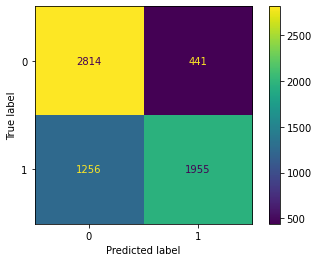

In [35]:
mlp_confusion_matrix = confusion_matrix(df_train_Y, mlp_train_results)
ConfusionMatrixDisplay(mlp_confusion_matrix).plot()

In [36]:
## mlp accuracy
acc = 0
for i in range(0, 2):
    acc+= mlp_confusion_matrix[i,i]
acc *100 / np.sum(mlp_confusion_matrix)

73.75502629137024

We can see that we've achieved about 73 acc score for multilayer perceptron.

## Explanations

### LIME explainer for xgboost model

In [37]:
df_train_X.columns.values

array(['Age', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'VIP_False', 'VIP_True',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e'], dtype=object)

In [38]:
def xgboost_classifier_fn(X):
    data_cols = ['Age', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'VIP_False', 'VIP_True',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e']
    X_D = xgb.DMatrix(X,feature_names=data_cols)

    prediction = xgb_model.predict(X_D)
    return prediction.reshape(-1, 1)

In [39]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    df_train_X.values, 
    feature_names=df_train_X.columns.values, 
    class_names=['False_Transport', 'True_Transport'], discretize_continuous=True )

In [40]:
data_index = 5

label = svm_model.predict(df_train_X.values[data_index].reshape((1, -1)))[0]

exp = explainer_lime.explain_instance(df_train_X.iloc[data_index], xgboost_classifier_fn, num_features=11, labels=(0,))

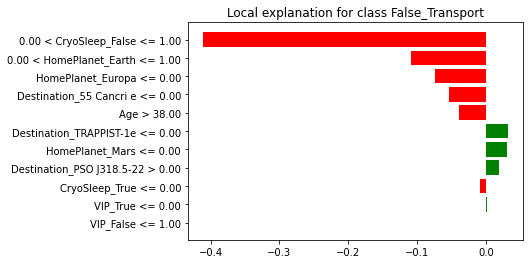

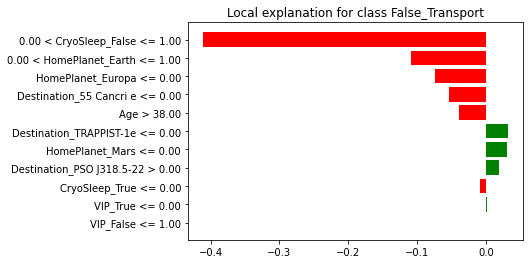

In [41]:
exp.as_pyplot_figure(label=0)

### LIME for MLP model

In [42]:
explainer = lime.lime_tabular.LimeTabularExplainer(df_train_X.values, feature_names=df_train_X.columns, 
                    class_names=['False_Transport', 'True_Transport'], discretize_continuous=True)

LIME is a local explainer, so we're using one random data in test set to interpret.

In [44]:
i = 5
exp = explainer.explain_instance(df_train_X.values[i], MLP_model.predict_proba, num_features=10, top_labels=1)

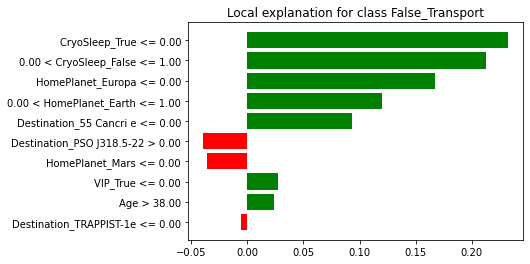

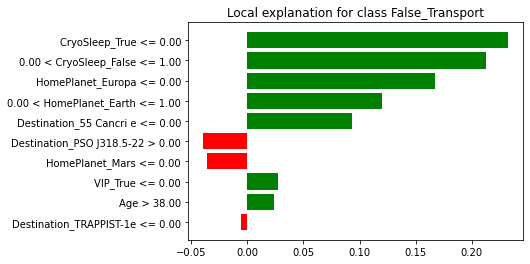

In [48]:
exp.as_pyplot_figure(label=0)

### SHAP for xgboost model

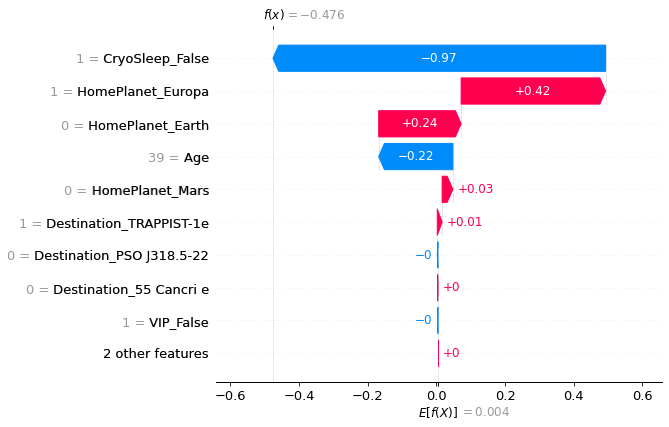

In [49]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(df_train_X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

### SHAP for MLP model

In [52]:
# explain the model's predictions using SHAP
explainer = shap.KernelExplainer(MLP_model.predict_proba, df_train_X[:100])

In [54]:
## local explanation for 5-th data in training set
i = 5
shap_values = explainer.shap_values(df_train_X.iloc[i, :] ,nsamples=100)

In [57]:
# shap.summary_plot(shap_values, df_train_X.iloc[5], feature_names=df_train_X.columns)
## for class False
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0]  ,df_train_X.iloc[i])

In [59]:
## for class True
shap.force_plot(explainer.expected_value[0], shap_values[1]  ,df_train_X.iloc[i])

### Dice-ml Explainer

In [63]:
import dice_ml

In [64]:
## prepare the whole dataset
train_dataset = df_train_X.copy()
train_dataset['Transported'] = df_train_Y

In [65]:
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=[],
                 outcome_name='Transported')

In [66]:
m = dice_ml.Model(model=MLP_model,
                  backend='sklearn')

In [67]:
exp = dice_ml.Dice(d, m)

In [68]:
# Generate counterfactual examples
query_instance = df_train_X[5:10].copy()
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")

100%|███████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


In [69]:
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,44.0,1,0,0,1,0,1,0,0,1,0,0



Diverse Counterfactual set (new outcome: 1.0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,5.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,1
1,44.0,0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,44.0,1.0,1,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,1
3,44.0,1.0,1,0.0,1.0,1,1.0,0.0,0.0,1.0,0.0,1


Query instance (original outcome : 0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,26.0,1,0,0,1,0,1,0,0,0,1,0



Diverse Counterfactual set (new outcome: 1.0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,26.0,1.0,0.0,0.0,1.0,1,1.0,0.0,1,0.0,1.0,1
1,1.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,1
2,7.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1
3,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,1.0,1


Query instance (original outcome : 0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,35.0,1,0,0,1,0,1,0,0,0,1,0



Diverse Counterfactual set (new outcome: 1.0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,35.0,1.0,1,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,1
1,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1.0,1
2,35.0,0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,1
3,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1


Query instance (original outcome : 1)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,14.0,0,1,0,0,1,1,0,1,0,0,1



Diverse Counterfactual set (new outcome: 0.0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,72.0,0.0,1.0,0,1,0,1.0,0.0,1.0,0.0,0.0,0
1,14.0,0.0,1.0,0.0,1,0,1.0,0.0,0,0.0,0.0,0
2,20.0,0.0,1.0,0.0,1,0,1.0,0.0,1.0,0.0,0.0,0
3,67.0,0.0,1.0,0.0,1,0,1.0,0.0,1.0,0.0,0.0,0


Query instance (original outcome : 0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,45.0,0,1,0,1,0,1,0,1,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,Age,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported
0,45.0,0.0,1.0,0.0,1.0,1,1.0,0,1.0,0.0,0.0,1
1,12.0,0.0,1.0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,45.0,0.0,1.0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,45.0,0,1.0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1


# MNIST Dataset

## Keras NN model
the model is from the toturial
https://keras.io/examples/vision/mnist_convnet/

In [79]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [71]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [72]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [73]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 14s 33ms/step - loss: 0.3739 - accuracy: 0.8862 - val_loss: 0.0898 - val_accuracy: 0.9757
Epoch 2/15
422/422 [==============================] - 14s 34ms/step - loss: 0.1150 - accuracy: 0.9644 - val_loss: 0.0616 - val_accuracy: 0.9830
Epoch 3/15
422/422 [==============================] - 14s 34ms/step - loss: 0.0852 - accuracy: 0.9737 - val_loss: 0.0471 - val_accuracy: 0.9880
Epoch 4/15
422/422 [==============================] - 16s 39ms/step - loss: 0.0713 - accuracy: 0.9777 - val_loss: 0.0437 - val_accuracy: 0.9893
Epoch 5/15
422/422 [==============================] - 17s 40ms/step - loss: 0.0632 - accuracy: 0.9804 - val_loss: 0.0399 - val_accuracy: 0.9900
Epoch 6/15
422/422 [==============================] - 18s 43ms/step - loss: 0.0561 - accuracy: 0.9826 - val_loss: 0.0346 - val_accuracy: 0.9912
Epoch 7/15
422/422 [==============================] - 15s 37ms/step - loss: 0.0531 - accuracy: 0.9827 - val_loss: 0.0341 - val_accuracy:

In [74]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02235320210456848
Test accuracy: 0.9926000237464905


## Explainers

### Using iNNvestigate